# Heat transfer for pipes

In [2]:
"""
importing the necessary libraries, do not modify
"""
%matplotlib inline 


from IPython.display import clear_output

import schemdraw as schem
import schemdraw.elements as e

import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.constants as sc

import sympy as sym



<img src="figures/fig_08_08.jpg" alt="my awesome sketch" width=75% >
<i>Fig. 1: Illustration of internal convection.</i>

The above sketch illustrates the focus of this notebook: How to quantify the heat transfer between a pipe, in which a fluid flows, and its surroundings. The heat transfer from the outer surface of the pipe to the outer flow is to defined in the previous chapter, external convection. In the following, this notebook establishes the tools necessary to solve the internal convection problem.

## Entry flow and fully developed internal flow

<img src="figures/fig_08_01.jpg" alt="my awesome sketch" width=100% >
<i>Fig. 2: Pipe flow nomenclature.</i>

### Python module

For internal flow, the module is loaded as:

In [2]:
from Libraries import HT_internal_convection as intconv


As an example, consider the flow of water in a pipe of diameter $D=10$ cm, length $L=10$m. The water thermodynamic properties are estimated at $T_f=50^\circ$C. The bulk velocity is $U_m=2$m/s.


In [3]:
from Libraries import thermodynamics as thermo
T_f = 50 #C
waterflow = thermo.Fluid('water',T_f,"C")

L_pipe = 10. #m
D_pipe = 0.1 #m
Um_pipe = 2 #m/s

In [4]:
pipe = intconv.PipeFlow(D= D_pipe, L=L_pipe,
                        rho=waterflow.rho, nu=waterflow.nu, Um=Um_pipe)

<img src="figures/fig_08_03.jpg" alt="my awesome sketch" width=100% >
<i> Fig. 3. Friction factor in pipe flow as a function of Re and relative surface roughness.</i>

A uniform flow entering a pipe (Fig. 2) first experiences streamwise variation of velocity to accommodate the wall boundary conditions. A boundary layer, of thickness $\delta$, forms on the wall and grows until its edge reaches the pipe centerline. This region is the hydrodynamic entrance region. Beyond that point, the flow becomes fully developed, which means that
<ul>
<li> In the laminar regime, the velocity profile is only a function of $r$,</li>
<li> In the turbulent regime, the <b>mean</b> velocity profile is only a function of $r$.</li>
</ul>
Friction drag or the force exerted by the flow onto the pipe wall governs the pressure gradient necessary to generate a desired flowrate. Calculation of the friction drag leads to the design of the mechanical force creating the pressure gradient. In fully developed (laminar or turbulent) regimes, the pressure gradient may be determined by
<p class='alert alert-danger'>
$$
-\frac{\Delta\overline{P}}{L}=f\,\frac{1}{D}\,\frac{\rho U_m^2}{2}
$$
</p>
where $D=2R$ and $L$ are the diameter and length of the pipe, respectively, and $f$ is the <b>friction factor</b>. The bulk velocity or average velocity is
<p class='alert alert-info'>
$$
U_m=\frac{\dot{m}}{\rho A_c}
$$
</p>
where $\dot{m}$ is the mass flux
$$
\dot{m}=\int_0^{2\pi}\int_0^R\rho \overline{u}(r)\,r\,dr d\theta=2\pi\int_0^R\rho \overline{u}(r)\,r\,dr
$$
and $A_c=\pi R^2$
The Reynolds number of the flow is based on the bulk velocity and pipe diameter:
<p class='alert alert-danger'>
$$
Re_D=\frac{\rho U_mD}{\mu}=\frac{4\dot{m}}{\pi D\mu}
$$
</p>
The friction factor in the laminar regime is rigorously derived:
$$
f = \frac{64}{Re_D}
$$
</p>
and is valid up to the critical Reynolds number $Re_{D,c}$, which in most pipe is around 2,000. Be aware that in certain research facilities, the flow can remain laminar for Reynolds numbers up to 10,000. The Reynolds 2,000 is not absolute, universal property, but is the best guess from most engineering applications.

Beyond the critical Reynolds number, $f$ is a function of the roughness to diameter ratio $\varepsilon=e/D$ (e is typically the standard deviation of the roughness height) and the Reynolds number. A trustworthy empirical correlation is the Colebrook formula:
<p class='alert alert-danger'>
$$
\frac{1}{\sqrt{f}}=-2\log_{10}\left[\frac{\varepsilon}{3.7}+\frac{2.51}{Re_D\sqrt{f}}\right]
$$
</p>
which is solved below for a range of relative roughness $\varepsilon$.

Often there is a need to determine the pump or blower power $P$ necessary to move the flow at a prescribed pressure drop:
<p class='alert alert-danger'>
$$
P=\frac{\dot{m}}{\rho}\Delta p= \underbrace{(\Delta p)A_c}_\text{force}\cdot U_m
$$
</p>

### Example of functions
Going back to our library, let's explore how to determine some of the properties defined above:

Reynolds number:

In [5]:
print("Re= %1.2e" %pipe.Re)

Re= 3.61e+05


Mass flow rate:

In [6]:
print("mass flowrate= %1.1f kg/s" %pipe.mdot)

mass flowrate= 15.5 kg/s


Compute the friction factor:

In [7]:
pipe.f_turbulent()

Pipe wall is assumed to be hydrodynamically smooth


In [8]:
print("f= %1.5f" %pipe.f)

f= 0.01397


The mean pressure gradient is:

In [9]:
print("-dP/dx= %1.0f Pa/m" %pipe.dPdx)

-dP/dx= 2760 Pa/m


## Heat transfer by internal convection

The temperature is expected to vary both in the streamwise direction and in the radial direction. To reduce the complexity of the problem, we define the mean temperature as:
$$
T_m=\frac{1}{\dot{m}C_p}\int_{A_c}\rho\,u\,C_p\, T\,dA_c
$$
where $\dot{m}$ is the mass flow rate, $rho$ and $C_p$ are the density and specific heat of the fluid and $A_c$ is the cross-sectional area of the pipe.
The local heat flux may be now expressed as:
$$
q_s''=h(T_s-T_m)
$$
where $h$ is the <b>local</b> convection heat transfer coefficient and $T_s$ is the surface temperature on the inner wall of the pipe. The variation of temperature in the <b>fully developed</b> flow can be shown to be governed by the following ODE:
<p class='alert alert-info'>
$$
\frac{dT_m}{dx}=\frac{P}{\dot{m}C_p}h(T_s-T_m)
$$
</p>
where $P$ is the perimeter of the pipe.
If the local heat flux is maintained constant over the length of the pipe $L$, the total heat rate is 
<p class='alert alert-danger'>
$$
q_\text{conv}=(PL)q_s''\, \text{$q_s''=$constant}
$$
</p>
and the streamwise distribution of the mean temperature is linear:
$$
T_m(x)=T_{m,i}+\frac{q_s''P}{\dot{m}C_p}x,\, \text{$q_s''=$constant}
$$
For the case of constant wall temperature $T_s$, the temperature distribution is the solution of the above ODE, thus of exponential nature. For practical applications, you most always need to compute the overall heat transfer and the outlet mean temperature $T_{m,o}$. The integration of the above ODE for $x=0$ to $x=L$ yields
<p class='alert alert-danger'>
$$
\frac{T_s-T_{m,o}}{T_s-T_{m,i}}=\exp\left(-\frac{PL}{\dot{m}C_p}\overline{h}\right),\, \text{$T_s=$constant}
$$
</p>
where 
$$
\overline{h}=\frac{1}{L}\int_0^L h(x)dx
$$
If you must compute the mean temperature at $x$ an integration from $0$ to $x$ yields
<FONT FACE="courier" style="color:blue">T_mx_Ts_constant(T_s,T_mi,P,L,mdot,Cp,hbar,x)</FONT>
<p class='alert alert-danger'>
$$
\frac{T_s-T_{m}(x)}{T_s-T_{m,i}}=\exp\left(-\frac{PL}{\dot{m}C_p}\overline{h}_x\right),\, \text{$T_s=$constant}
$$
</p>
where 
$$
\overline{h}_x=\frac{1}{L}\int_0^x h(x')dx'
$$
The computation of the total heat transfer rate can be shown to write:
<p class='alert alert-danger'>
$$
q_\text{conv}=\overline{h}(PL)\Delta T_\text{lm},\, \text{$T_s=$constant}
$$
</p>
with the log mean temperature
<FONT FACE="courier" style="color:blue">log_mean_temperature(T_s,T_o,T_i)</FONT>
<p class='alert alert-danger'>
$$
\Delta T_\text{lm}=\cfrac{T_{m,i}-T_{m,o}}{\ln\left(\cfrac{T_s-T_{m,o}}{T_s-T_{m,i}}\right)}
$$
</p>
In many problem, $T_s$ is not defined but the outside ambient temperature $T_\infty$, the thermal conductivity of the pipe is known. One needs to determine the total resistance of the system $R_\text{tot}$, which requires calculating the heat transfer coefficient of the forced or natural convection, occuring on the outside of the pipe, the radiation coefficient if needed, the thermal resistance due by conduction within the pipe, which may include multiple components in the presence of insulation for example, and the internal convection heat transfer coefficient (to be defined below). In such cases, the variation of temperature between inlet and outlet becomes:
<FONT FACE="courier" style="color:blue">T_mo_T_infty(T_infty,T_mi,P,L,mdot,Cp,R_tot)</FONT>
<p class='alert alert-danger'>
$$
\frac{T_\infty-T_{m,o}}{T_\infty-T_{m,i}}=\exp\left(-\frac{1}{\dot{m}C_pR_\text{tot}}\right)
$$
</p>
and the total heat transfer rate is
<p class='alert alert-danger'>
$$
q=\frac{\Delta T_\text{lm}}{R_\text{tot}}
$$
</p>
The equations derived in this cell enable:
<ul>
<li> The computation of the internal convection heat transfer coefficient if $T_{m,i}$ and $T_{m,o}$ are known.</li>
<li> The computation of $T_{m,i}$ or $T_{m,o}$ if one is known and $\overline{h}$ is known </li>
<li> The computation of the required mass flux to achieve given $T_{m,i}$ and $T_{m,o}$, albeit through an iterative process</li>
</ul>

## Correlations for convection heat transfer coefficients in internal pipe flows

Here we detailed only the correlations for fully developed flows. For laminar flows, the nusselt numbers are constant, thus the library <FONT FACE="courier" style="color:blue">HT_internal_convection</FONT> provides directly $\overline{h}$:
<FONT FACE="courier" style="color:blue">laminar_isoflux() </FONT>
<p class='alert alert-danger'>
$$
Nu=\frac{hD}{k}=4.36,\, \text{$q_s''=$constant}
$$
</p>
<FONT FACE="courier" style="color:blue">laminar_isothermal() </FONT>
<p class='alert alert-danger'>
$$
Nu=\frac{hD}{k}=4.36,\, \text{$q_s''=$constant}
$$
</p>


In [10]:
pipe.laminar_isoflux()
print("Nu= %1.2f for laminar isoflux" %pipe.Nu)
pipe.laminar_isothermal()
print("Nu= %1.2f for laminar isothermal" %pipe.Nu)

Nu= 4.36 for laminar isoflux
Nu= 3.66 for laminar isothermal


In turbulent flows, there is a choice of correlations:
<FONT FACE="courier" style="color:blue">Dittus_Boelter(Re,Pr,mode) </FONT>
<p class='alert alert-danger'>
$$
Nu=\frac{hD}{k}=0.023Re^{4/5}Pr^n
$$
</p>
with mode being either <FONT FACE="courier" style="color:blue">'cooling'</FONT> or <FONT FACE="courier" style="color:blue">'heating'</FONT>

In [11]:
pipe.Dittus_Boelter(mode='cooling',Pr=waterflow.Pr)
print("Nu= %1.0f for cooling" %pipe.Nu)
pipe.Dittus_Boelter(mode='heating',Pr=waterflow.Pr)
print("Nu= %1.0f for heating" %pipe.Nu)

Nu= 940 for cooling
Nu= 1067 for heating


<FONT FACE="courier" style="color:blue">Sieder_Tate(Re,Pr,mu,mu_s) </FONT>
<p class='alert alert-danger'>
$$
Nu=\frac{hD}{k}=0.027Re^{4/5}Pr^{1/3}\left(\cfrac{\mu}{\mu_s}\right)^{0.14}
$$

In [12]:
T_s = 75 #C
watersurface = thermo.Fluid('water',thermo.C2K(T_s))
pipe.Sieder_Tate(mu=waterflow.mu,mu_s=watersurface.mu,Pr=waterflow.Pr)
print("Nu= %1.0f" %pipe.Nu)

Nu= 1213


<FONT FACE="courier" style="color:blue">Gnielinski(Re,Pr,f) </FONT>
<p class='alert alert-danger'>
$$
Nu=\frac{hD}{k}=\frac{(f/8)(Re-1000)Pr}{1+12.7(f/8)^{1/2}(Pr^{2/3}-1)}
$$
</p>

In [13]:
pipe.Gnielinski(f=pipe.f, Pr=waterflow.Pr)
print("Nu= %1.0f" %pipe.Nu)

Nu= 1311


<FONT FACE="courier" style="color:blue">Skupinski(Re,Pr) </FONT>
<p class='alert alert-danger'>
$$
Nu=\frac{hD}{k}=4.82+0.0185\left(Re\,Pr\right)^{0.827},\, \text{$q_s''=$constant}
$$
</p>

In [14]:
pipe.Skupinski(Pr=waterflow.Pr)
print("Nu= %1.0f" %pipe.Nu)

Nu= 2089


<FONT FACE="courier" style="color:blue">Seban(Re,Pr) </FONT>
<p class='alert alert-danger'>
$$
Nu=\frac{hD}{k}=5.0+0.025\left(Re\,Pr\right)^{0.8},\, \text{$T_s=$constant}
$$
</p>

In [15]:
pipe.Seban(Pr=waterflow.Pr)
print("Nu= %1.0f" %pipe.Nu)

Nu= 1931


## Natural convection around cylinder

<img src="figures/fig_09_08.jpg" alt="my awesome sketch" width=75% >
<i>Fig. 4: Illustration of the flow induced by natural convection around a cylinder. Insert shows the angular distribution of the local Nu.</i>

In a fluid entirely at rest, a heated surface transfers its heat via pure conduction. Natural convection is the enhanced heat transfer between a body of fluid at rest (at infinity) and a heated surface through the creation of a convective flow driven by buoyancy forces. Fig. 4 illustrates a natural convection flow occuring around a cylinder. The fluid at the bottom of the cylinder $\theta=0$ becomes buoyant through heat transfer between the cylinder and the fluid and rises along the surface of the cylinder. This process creates two boundary layers that merge at $\theta = \pi$ to create a vertical jet-like flow, also called a plume. Plumes are characteristic flows of natural convection, i.e. they are found irrespective of the geometry of the heated object.

The library is called in the following way:

In [16]:
from Libraries import HT_natural_convection as natconv

The non-dimensional numbers relevant to natural convection are:
the Grashof number
<FONT FACE="courier" style="color:blue">Grashof(g,beta,DT,D,nu) </FONT>
<p class='alert alert-danger'>
$$
Gr = \frac{g\beta(\Delta T)D^3}{\nu^2}
$$
</p>
and the Rayleigh number 
<FONT FACE="courier" style="color:blue">Rayleigh(g,beta,DT,D,nu,alpha) </FONT>
<p class='alert alert-danger'>
$$
Ra = Gr.Pr= \frac{g\beta(\Delta T)D^3}{\nu\alpha}
$$
</p>
where $g$ is the gravity magnitude, $\beta$ is the volumetric thermal expansion coefficient at a given pressure $p$
$$
\beta = -\frac{1}{\rho}\left(\frac{\partial\rho}{\partial T}\right)_p
$$
$\Delta T$ is the absolute temperature difference between the heated surface temperature $T_s$ and the fluid temperature at infinity $T_\infty$, $\Delta T= \vert T_s-T_\infty\vert$, $D$ is the characteristic length of the system (here the diameter) and $\nu$ and $\alpha$ are the kinematic viscosity and the thermal diffusivity, both of dimensions $\text{m$^2$/s}$. 
Note that for the ideal gas law
$$
p =\rho \frac{R}{M}T\text{ or } \rho = \frac{p}{\frac{R}{M}T}
$$
thus the expansion coefficient is 
<p class='alert alert-info'>
$$
\beta = \frac{1}{T}\text{ for an ideal gas, $T$ in K}
$$
</p>
For a liquid, $\beta$ must be interpolated from a table. All thermodynamics quantities involved are to be defined at the film temperature which is the arithmetic mean
<p class='alert alert-info'>
$$
T_f=\frac{T_s+T_\infty}{2} 
$$
</p>

In [17]:
#air
T_infty = 10#C
T_s = 50#C
D = 0.1#m
T_f = (T_s+T_infty)/2
airflow = thermo.Fluid('air',T_f,"C")
Gr= natconv.Gr(beta=airflow.beta,D=D,DT=T_s-T_infty,nu=airflow.nu)
print('Natural convection Gr= %1.2e'%Gr)
Ra= natconv.Ra(alpha=airflow.alpha,beta=airflow.beta,D=D,DT=T_s-T_infty,nu=airflow.nu)
print('Natural convection Ra= %1.2e'%Ra)

Natural convection Gr= 5.03e+06
Natural convection Ra= 3.57e+06


The Grashof and Rayleigh number quantify the ratio of buoyancy to viscous forces. When they are large enough, a convective flow sets in and the heat transfer increases in comparison to pure conduction. The Nusselt number, ratio of convective to conduction heat transfer (i.e. $>1$ in the presence of a convection flow) is typically a power law of the Rayleigh number. In the case of the flow around a cylinder with isothermal surface temperature, there are two correlations:
<FONT FACE="courier" style="color:blue">Morgan(Ra) </FONT>
<p class='alert alert-danger'>
$$
\overline{Nu}=\frac{\overline{h}D}{k}=C\,Ra^n
$$
</p>
<FONT FACE="courier" style="color:blue">Churchill-Chu(Ra,Pr) </FONT>
<p class='alert alert-danger'>
$$
\overline{Nu}=\frac{\overline{h}D}{k}=\left[0.60+\frac{0.387Ra^{1/6}}{\left[1+\left(\frac{0.559}
{Pr}\right)^{9/16}\right]^{8/27}}
\right]^2 
$$
</p>
Both are valid for $Ra\leq10^{12}$. The Nusselt is averaged over the perimeter of the cylinder to account for the angular variation of heat transfer discussed earlier. The heat transfer from natural convection from a heated cylinder of diameter $D$ and length $L$ is
<p class='alert alert-info'>
$$
q=\overline{h}(\pi DL)(T_s-T_\infty)=\frac{1}{R_\text{th,conv}}(T_s-T_\infty)
$$
</p>
where $R_\text{th,conv}$ may computed with <FONT FACE="courier" style="color:blue">R_th_convection(h,A)</FONT>


In [18]:
airnatconv = natconv.HorizontalCylinder(correlation='Morgan',Ra=Ra)
print("Morgan correlation: Nu= %1.2f" %airnatconv.Nu)
airnatconv = natconv.HorizontalCylinder(correlation='Churchill-Chu',Ra=Ra,Pr=airflow.Pr)
print("Churchill-Chu correlation: Nu= %1.2f" %airnatconv.Nu)

Morgan correlation: Nu= 20.87
Churchill-Chu correlation: Nu= 20.91


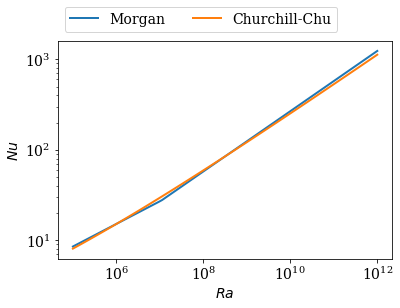

In [19]:
font = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 14,
        }

from matplotlib.ticker import FormatStrFormatter
plt.rc('font', **font)
N = 100
Ra = np.logspace(5,12,N)
Nu_Morgan = np.zeros(N)
Nu_ChurchillChu = np.zeros(N)
Pr = 1.0
for i in range(N):
    flow = natconv.HorizontalCylinder(correlation='Morgan',Ra=Ra[i])
    Nu_Morgan[i] = flow.Nu
    flow = natconv.HorizontalCylinder(correlation='Churchill-Chu',Ra=Ra[i],Pr=Pr)
    Nu_ChurchillChu[i] = flow.Nu

plt.loglog(Ra,Nu_Morgan, label = r"Morgan",lw = 2)
plt.loglog(Ra,Nu_ChurchillChu, label = r"Churchill-Chu", lw= 2)
plt.xlabel(r"$Ra$")
plt.ylabel(r"$Nu$")
plt.legend(loc=3, bbox_to_anchor=[0., 1.01], ncol=2, shadow=False, fancybox=True)
plt.show()

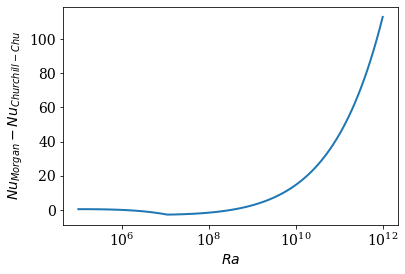

In [20]:
plt.semilogx(Ra,Nu_Morgan-Nu_ChurchillChu,lw = 2)
plt.xlabel(r"$Ra$")
plt.ylabel(r"$Nu_{Morgan}-Nu_{Churchill-Chu}$")
plt.show()

## Assignment

<ol>
<li> Read this entire notebook. Using the textbook, add restrictions and range of validity for the above correlations when applicable. Add the entry length Nu correlation for laminar flow</li>
<li> Add a section on entrance flow</li>
<li> How should the entrance flow region be treated in turbulent flows?</li>
<li>Solve 8.31, 8.36, 8.43</li>
</ol>

### 8.31

<img src="figures/probun_08_07.jpg" alt="my awesome sketch" width=50% >
To cool a summer home without using a vapor-compression refrigeration cycle, air is routed through a plastic pipe ($k=0.15\text{ W/m.K}$, $D_i=0.15\text{ m}$, $D_o=0.17\text{ m}$) that is submerged in an adjoining body of water. The water temperature is nominally at $T_\infty= 17^\circ\text{C}$, and a convection coefﬁcient of $h_o\approx 1500\text{ W/m$^2$. K}$ is maintained at the outer surface of the pipe.

If air from the home enters the pipe at a temperature of $T_{m,i}= 29^\circ\text{C}$ and a volumetric ﬂow rate of $\dot{\forall}_i= 0.025\text{ m$^3$/s}$, what pipe length $L$ is needed to provide a discharge temperature of $T_{m,o}=21^\circ\text{C}$? What is the fan power required
to move the air through this length of pipe if its inner surface is smooth?

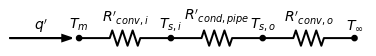

In [6]:
from Libraries import HT_thermal_resistance as res

Rp = []
Rp.append(res.Resistance("$R'_{conv,i}$", "W/m"))
Rp.append(res.Resistance("$R'_{cond,pipe}$", "W/m"))
Rp.append(res.Resistance("$R'_{conv,o}$", "W/m"))

d = schem.Drawing()
d.add(e.DOT, label = r"$T_m$")
d.add(e.RES, d = 'right', label = Rp[0].name)
d.add(e.DOT, label = r"$T_{s,i}$")
R1 = d.add(e.RES, d = 'right', label = Rp[1].name)
d.add(e.DOT, label = r"$T_{s,o}$")
d.add(e.RES, d='right', label = Rp[2].name)
d.add(e.DOT, label="$T_\infty$")
L1 = d.add(e.LINE, toplabel = "$q'$", endpts = [[-2.25, 0], [-0.25, 0]])
d.labelI(L1, arrowofst = 0)
d.draw()

In [9]:
from Libraries import thermodynamics as thermo
from Libraries import HT_internal_convection as intconv

k_pipe = 0.15
Di = 0.15
Do = 0.17
T_infty = 17
h_o = 1500
T_mi = 29
T_mo = 21

Qdot = 0.025
T_m = (T_mi + T_mo)/2

airi = thermo.Fluid('air',T_mi,'C')
airm = thermo.Fluid('air',T_m,'C')
airflow = intconv.PipeFlow(D=Di,L=1,mdot = airi.rho*Qdot, nu=airm.nu, rho =airi.rho)


### 8.36

Hot water at mean temperature $T_m=50\text{$^\circ$C}$ is routed from one building in which it is generated to an adjoining building in which it is used for space heating. Transfer between the buildings occurs in a steel pipe ($k=60\text{ W/m.K}$) of $100 \text{ mm}$ outside diameter and 8-mm wall thickness. During the winter, representative environmental conditions involve air at $T_\infty= -5\text{$^\circ$C}$ and $V_\infty=3\text{ m/s}$ in cross ﬂow over the pipe.
Using the Churchill Bernstein and Dittus Boehler correlations, calculate the total heat transfer rate <b>per unit length</b> $q'$, the daily energy cost $Q'=q'\times 24\text{ h/d}$ per meter and the cost per day and per meter assuming an electricity cost of $\text{\$}0.05\text{/kW.h}$.

In [1]:
T_m = 50 #C
k = 60 #W/M*K
D_o = 0.1 #m
D_i = 0.084 #m 
T_infty = -5 #C
V_infty = 3 #m/s
t = 0.008 #m 


from libraries import HT_thermal_resistance as res
Rp =[]
Rp.append(res.Resistance("$R'_{conv,int}", "W/m"))
Rp.append(res.Resistance("$R'_{cond,p}", "W/m"))
Rp.append(res.Resistance("$R'_{conv,ext}", "W/m"))



ModuleNotFoundError: No module named 'libraries'

### 8.42

Atmospheric air enters a $10\text{ m}$-long, $150\text{ mm}$-diameter uninsulated heating duct at $60\text{$^\circ$C}$ and $0.04\text{ kg/s}$. The duct surface temperature is approximately constant at $Ts=15\text{$^\circ$C}$.

(a) What are the outlet air temperature, the heat rate q, and pressure drop $\Delta p$ for these conditions?

(b) To illustrate the tradeoff between heat transfer rate and pressure drop considerations, calculate $q$ and $\Delta p$ for diameters in the range from $0.1$ to $0.2\text{ m}$. In your analysis, maintain the total surface area,
$A_s=\pi DL$, at the value computed for part (a). Plot $q$, $\Delta p$, and $L$ as a function of the duct diameter.